<a href="https://colab.research.google.com/github/QaziSaim/CASE-STUDIES/blob/main/Workflows_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install langgraph
%pip install langchain_google_genai


In [2]:
from langgraph.graph import START,StateGraph,END
from typing import TypedDict
class BMIState(TypedDict):
  weight_kg:float
  height_m:float
  bmi:float
  category:str

def calculate_bmi(state:BMIState)->BMIState:
  weight = state['weight_kg']
  height = state['height_m']
  bmi = round(weight/(height**2),2)
  return {'bmi':bmi}
graph = StateGraph(BMIState)
graph.add_node('calculate_bmi',calculate_bmi)
graph.add_edge(START,'calculate_bmi')
graph.add_edge('calculate_bmi',END)
workflow = graph.compile()
initial_state = {'weight_kg':97,'height_m':5.11}
final_state = workflow.invoke(initial_state)
print(final_state)

{'weight_kg': 97, 'height_m': 5.11, 'bmi': 3.71}


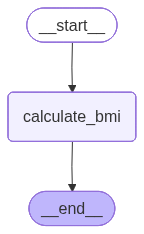

In [3]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [17]:
class LLMState(TypedDict):
  question:str
  answer:str
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model='gemini-2.5-flash',api_key=userdata.get('GEMINI_API'))

def generate_something(state:LLMState)->LLMState:
  query = state['question']
  answer = model.invoke(f'Answer the following question\n{query}')
  return {'answer':answer}

graph = StateGraph(LLMState)
graph.add_node('generate_something',generate_something)
graph.add_edge(START,'generate_something')
graph.add_edge('generate_something',END)
workflow = graph.compile()
initial_state = {'question':'What 0/0 is not define'}
final_state = workflow.invoke(initial_state)
# print(final_state)
final_state['answer'].content

'The reason 0/0 is **undefined** (specifically, it\'s an **indeterminate form**) comes down to the fundamental definition of division.\n\nLet\'s break down division:\n\nWhen you say $\\frac{a}{b} = c$, it means that $a = b \\times c$.\n\n1.  **Consider a normal division:**\n    *   $\\frac{6}{2} = 3$ because $6 = 2 \\times 3$. This works perfectly.\n\n2.  **Consider division of zero by a non-zero number:**\n    *   $\\frac{0}{5} = 0$ because $0 = 5 \\times 0$. This also works perfectly. The answer is unique.\n\n3.  **Consider division by zero (non-zero numerator):**\n    *   Let\'s try to calculate $\\frac{5}{0} = x$.\n    *   According to the definition, this would mean $5 = 0 \\times x$.\n    *   However, $0 \\times x$ is always $0$, no matter what $x$ is.\n    *   So, the equation becomes $5 = 0$, which is a **contradiction**. There is no number $x$ that can satisfy this equation. That\'s why $\\frac{5}{0}$ is undefined due to **impossibility**.\n\n4.  **Now, let\'s look at 0/0:**\n

In [25]:
class BlogState(TypedDict):
  title:str
  content:str
  blog:str
  evaluate:int

def outline(state:BlogState)->BlogState:
  title = state['title']
  query = f"Generate an outline of given topic {title}"
  content = model.invoke(query).content
  return {'content':content}

def blog(state:BlogState)->BlogState:
  content = state['content']
  query = f'Generate a blog by given content\n{content}'
  blog = model.invoke(query)
  return {'blog':blog}

def evaluate(state:BlogState)->BlogState:
  blog = state['blog']
  query = f'rate the below blog out of 10\n{blog}'
  evaluate = model.invoke(query)
  return {'evaluate':evaluate}

graph = StateGraph(BlogState)
graph.add_node('outline',outline)
graph.add_node('blog',blog)
graph.add_node('evaluate',evaluate)

graph.add_edge(START,'outline')
graph.add_edge('outline','blog')
graph.add_edge('blog','evaluate')
graph.add_edge('evaluate',END)

workflow = graph.compile()
initial_state = {
    'title':'Web Technologies'
}
final_state = workflow.invoke(initial_state)
final_state['evaluate'].content

This blog post is an exceptionally thorough and well-structured "Comprehensive Guide to Web Technologies." It covers an enormous amount of ground, from fundamental concepts to cutting-edge advancements, in a clear and organized manner.

Here's a breakdown of its strengths and minor areas for improvement:

**Strengths:**

1.  **Exceptional Comprehensiveness:** The blog post lives up to its title. It covers almost every significant aspect of web technologies, including:
    *   Foundational concepts (Internet vs. Web, Client-Server, Protocols).
    *   Frontend technologies (HTML, CSS, JavaScript, frameworks, build tools).
    *   Backend technologies (languages, frameworks, web servers, APIs, authentication).
    *   Data management (SQL, NoSQL, ORMs, caching).
    *   Protocols and standards.
    *   Deployment and DevOps (VCS, Cloud, Containers, CI/CD, Monitoring).
    *   Web Security (OWASP Top 10, measures).
    *   Performance and Optimization (Metrics, techniques, rendering strat

In [24]:
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

In [28]:
class EvaluationSchema(BaseModel):
  feedback:str = Field(description='Detailed feedback for the essay')
  score:str = Field(description='rate out of 10',ge=0,le=10)

structured_model = model.with_structured_output(EvaluationSchema)

class UPSCState(TypedDict):
  essay:str
  language:str
  analysis:str
  clarity:str
  overall:str
  individual_scores:Annotated[list[int],operator.add]
  avg_score:float

graph = StateGraph(UPSCState)